## GAN - Aula Prática

## Configurações

Importando módulos necessários e baixando os datasets.

In [56]:
import glob
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as K
from torchvision.utils import make_grid

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from skimage import io
from torchinfo import summary

In [ ]:
!mkdir -p ./data
!wget -O ./data/cebradata.zip -nc https://www.kaggle.com/api/v1/datasets/download/alsaniipe/cebradata
!wget -O ./data/anime-faces.zip -nc https://www.kaggle.com/api/v1/datasets/download/soumikrakshit/anime-faces
!unzip -q -n data/cebradata.zip -d ./data/cebradata
!unzip -q -n data/anime-faces.zip -d ./data/anime-faces

# Introdução

GANs (Generative Adversarial Networks) são uma arquitetura de rede neural que tem como objetivo gerar novos dados a partir de um conjunto de dados de treinamento. A ideia é que a rede neural seja capaz de aprender a distribuição dos dados de treinamento e, a partir disso, gerar novos dados que sejam semelhantes aos dados de treinamento. Neste notebook, vamos implementar uma GAN para gerar imagens de personagens de anime.

## Dataset

O dataset que vamos utilizar é o [Anime Faces](https://www.kaggle.com/datasets/soumikrakshit/anime-faces), que contém imagens de personagens de anime. O dataset contém 63.000 imagens de personagens de anime, com dimensões 64x64 pixels.

Escolhemos este dataset por ser relativamente pequeno e por conter imagens de personagens de anime, que são mais simples e possuem menos variações do que imagens de pessoas reais. Isso facilita o treinamento da GAN.

In [165]:
anime_faces_path = './data/anime-faces'

In [57]:
# function to plot samples and metadata of a dataset
def plot_dataset(dataset, n_rows=4, n_cols=4, figsize=(6, 6), denormalize=False):
    print(f'Number of samples: {len(dataset)}')
    print(f'Sample shape: {dataset[0][0].shape}')

    samples = np.random.randint(0, len(dataset), size=(n_rows, n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i in range(n_rows):
        for j in range(n_cols):
            image, _ = dataset[samples[i, j]]
            if denormalize:
                image = K.normalize(image, -1, 2)
                image = image.clamp(0, 1)
            image = image.permute(1,2,0)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
    
    plt.show()

In [58]:
anime_faces = ImageFolder(
    anime_faces_path,
    transform=transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Resize((64, 64)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

In [ ]:
plot_dataset(anime_faces, n_cols=8, n_rows=8, denormalize=True, figsize=(8, 8))

## Modelo

A GAN é composta por duas redes neurais: o gerador e o discriminador. O gerador é responsável por gerar novas imagens, enquanto o discriminador é responsável por distinguir entre imagens reais e imagens geradas. O treinamento da GAN é feito de forma adversarial: o gerador tenta gerar imagens que enganem o discriminador, enquanto o discriminador tenta distinguir entre imagens reais e imagens geradas.

A imagem abaixo ilustra a ideia por trás da arquitetura de uma GAN:

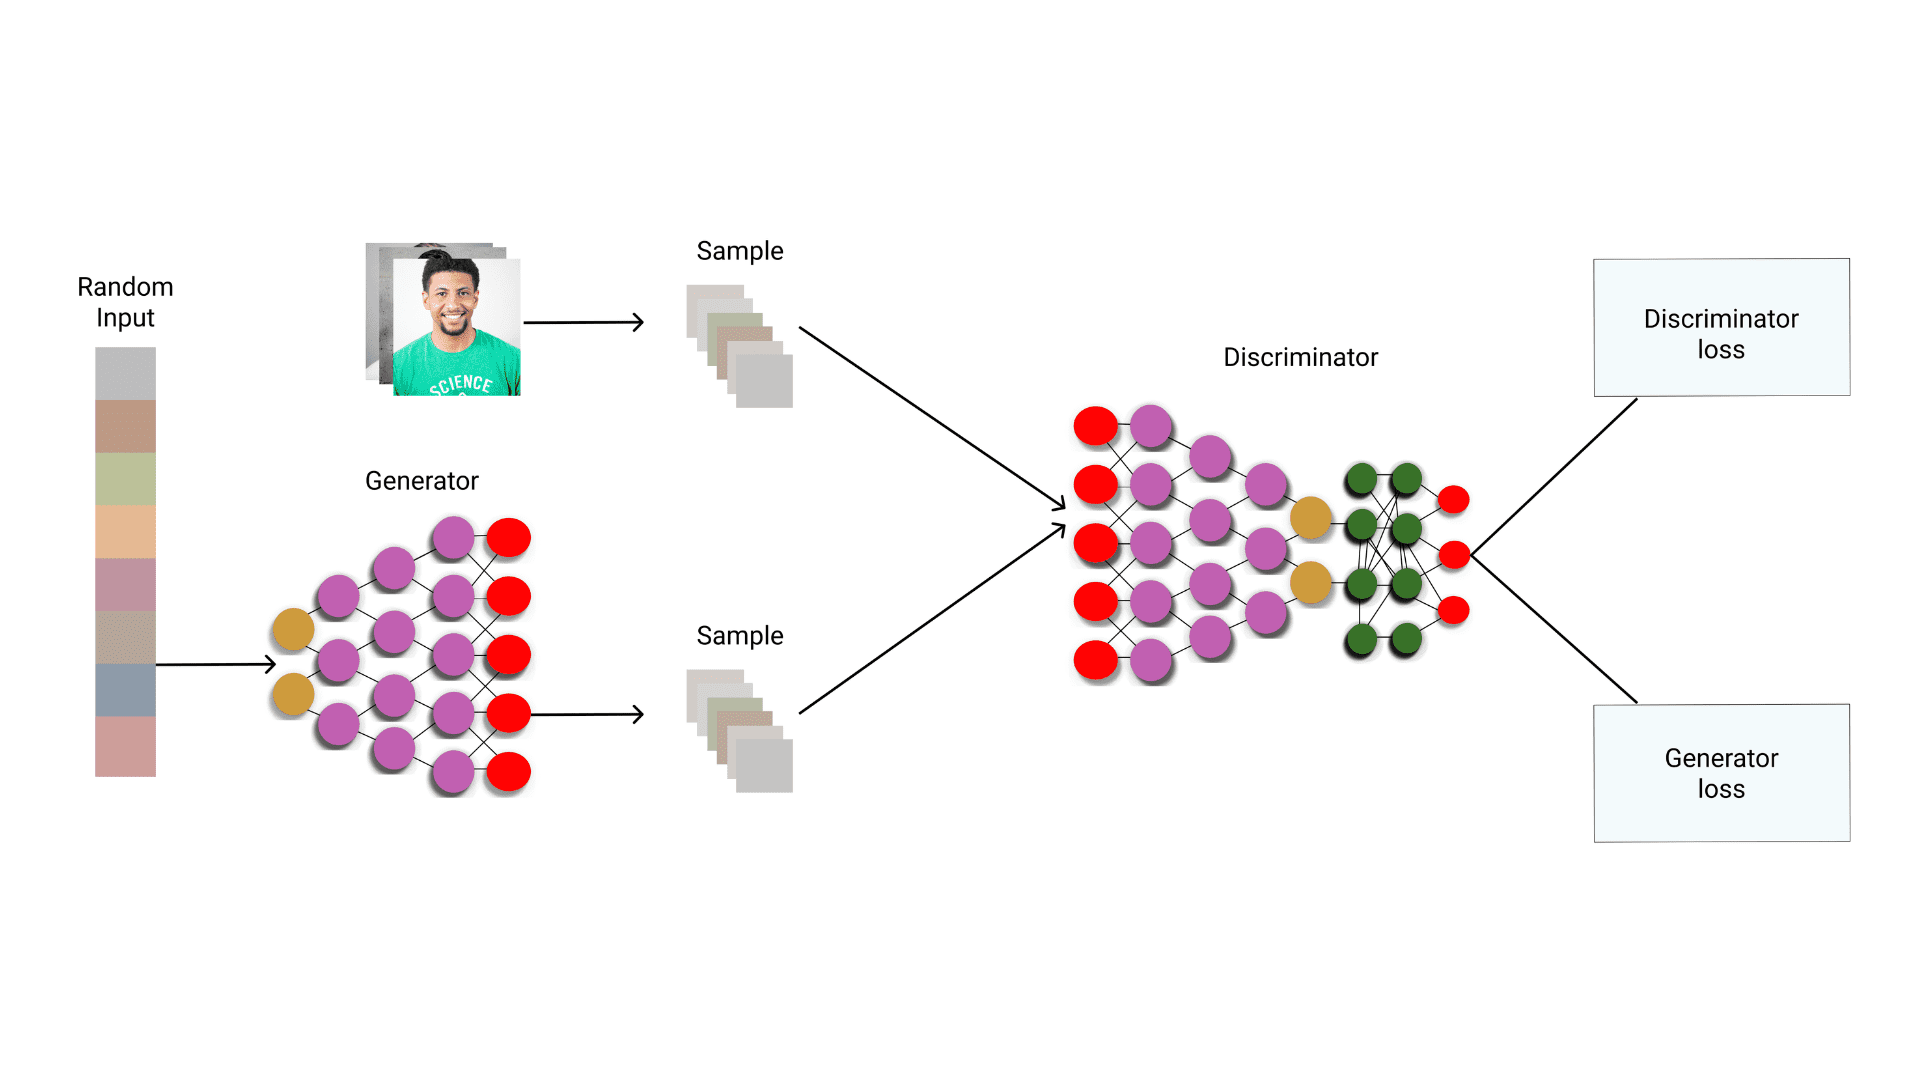

### Gerador

O gerador é uma rede neural que recebe um vetor de valores aleatórios como entrada (a semente da geração) e gera uma imagem como saída. A ideia é que o gerador aprenda a mapear vetores de números aleatórios para imagens que sejam semelhantes às imagens de treinamento. O gerador é treinado para enganar o discriminador, ou seja, para gerar imagens que o discriminador classifica como reais.

In [60]:
def plot_generated_images(generator, num_images=64, latent_dim=128, figsize=(6, 6), device='cpu', denormalize=False):
    # generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, 1, 1).to(device)
        generated_images = generator(noise).cpu()

    generated_images = generated_images.permute(0, 2, 3, 1)
    if denormalize:
        generated_images = K.normalize(generated_images, -1, 2)  # Normalize to (0, 1)
    
    n_rows = int(math.sqrt(num_images))
    n_cols = int(math.sqrt(num_images))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i in range(n_rows):
        for j in range(n_cols):
            axes[i, j].imshow(generated_images[i * n_cols + j])
            axes[i, j].axis('off')
    
    plt.show()

In [61]:
class Generator(nn.Module):
    def __init__(self, latent_size=128, output_dim=3):
        super(Generator, self).__init__()

        # latent_size is the size of the input noise vector
        self.latent_size = latent_size
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, bias=False),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.ConvTranspose2d(64, output_dim, kernel_size=4, stride=2, padding=1, bias=False),  # (output_dim, 64, 64)
            nn.Tanh()
        )
    
    def forward(self, x=None, batch_size=1):
        if x is None:
            device = next(self.parameters()).device
            x = torch.randn(batch_size, self.latent_size, 1, 1, device=device)
        
        return self.net(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(output_dim=3)
generator.to(device)
summary(generator, (256, 128, 1, 1))

In [ ]:
plot_generated_images(generator, device=device, num_images=64, denormalize=True, figsize=(8, 8))

### Discriminador

O discriminador é uma rede neural que recebe uma imagem como entrada e classifica se a imagem é real (vinda do conjunto de treinamento) ou falsa (gerada). O discriminador é treinado para distinguir entre imagens reais e falsas.

In [64]:
class Discrimiminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discrimiminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False), # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, bias=False),  # (1, 1, 1)
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
discriminator = Discrimiminator()
discriminator.to(device)
summary(discriminator, (128, 3, 64, 64))

## Treinando o modelo

Vamos treinar o modelo para reconstruir imagens do dataset. O modelo será treinado por 32 épocas, com batch size 128 e otimizador Adam.

In [162]:
def train(
    generator,
    discriminator,
    train_loader,
    val_loader,
    g_optimizer,
    d_optimizer,
    criterion,
    device,
    epochs=24,
    plot_frequency=None,
):
    generator.to(device)
    discriminator.to(device)

    g_losses_train = []
    d_losses_train = []
    d_accuracies_train = []
    real_scores_train = []
    fake_scores_train = []

    if val_loader is not None:
        g_losses_val = []
        d_losses_val = []
        d_accuracies_val = []
        real_scores_val = []
        fake_scores_val = []

    for epoch in range(epochs):
        generator.train()
        discriminator.train()

        g_loss_train = 0.0
        d_loss_train = 0.0
        d_batch_accuracy = 0.0
        real_score = 0.0
        fake_score = 0.0

        for i, (images, _) in (
            pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')
        ):
            real_images = images.to(device, non_blocking=True)
            batch_size = real_images.size(0)


            # Train discriminator
            d_optimizer.zero_grad()

            real_outputs = discriminator(real_images)
            real_labels = torch.ones_like(real_outputs, device=device)
            real_loss = criterion(real_outputs, real_labels)

            noise = torch.randn(batch_size, generator.latent_size, 1, 1, device=device)
            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images.detach())
            fake_labels = torch.zeros_like(fake_outputs, device=device)
            fake_loss = criterion(fake_outputs, fake_labels)

            batch_accuracy = (torch.mean(real_outputs >= 0.5, dtype=torch.float32) + torch.mean(fake_outputs < 0.5, dtype=torch.float32)) / 2
            d_batch_accuracy += batch_accuracy.item()

            d_loss = real_loss + fake_loss
            d_loss_train += d_loss.item()
            real_score += real_outputs.mean().item()
            fake_score += fake_outputs.mean().item()
            
            d_loss.backward()
            d_optimizer.step()

            # Train generator
            g_optimizer.zero_grad()

            noise = torch.randn(batch_size, generator.latent_size, 1, 1, device=device)
            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images)
            
            g_loss = criterion(fake_outputs, real_labels)
            g_loss_train += g_loss.item()

            g_loss.backward()
            g_optimizer.step()

            pbar.set_description(
                f'Epoch {epoch+1}/{epochs} G_Loss: {g_loss_train/((i+1)):.4f} D_Loss: {d_loss_train/(i+1):.4f}'
            )

        g_loss_train /= (len(train_loader))
        d_loss_train /= len(train_loader)
        d_accuracy_train = d_batch_accuracy / (len(train_loader))
        real_score /= len(train_loader)
        fake_score /= len(train_loader)

        g_losses_train.append(g_loss_train)
        d_losses_train.append(d_loss_train)
        d_accuracies_train.append(d_accuracy_train)
        real_scores_train.append(real_score)
        fake_scores_train.append(fake_score)

        if val_loader is not None:
            with torch.no_grad():
                generator.eval()
                discriminator.eval()

                g_loss_val = 0.0
                d_loss_val = 0.0
                d_batch_accuracy = 0.0
                real_score = 0.0
                fake_score = 0.0

                for images, _ in val_loader:
                    real_images = images.to(device, non_blocking=True)
                    batch_size = real_images.size(0)


                    # Evaluate discriminator

                    real_outputs = discriminator(real_images)
                    real_labels = torch.ones_like(real_outputs, device=device)
                    real_loss = criterion(real_outputs, real_labels)

                    # Generate fake images
                    noise = torch.randn(batch_size, generator.latent_size, 1, 1, device=device)
                    fake_images = generator(noise)

                    fake_outputs = discriminator(fake_images)
                    fake_labels = torch.zeros_like(fake_outputs, device=device)
                    fake_loss = criterion(fake_outputs, fake_labels)

                    batch_accuracy = (torch.mean(real_outputs >= 0.5, dtype=torch.float32) + torch.mean(fake_outputs < 0.5, dtype=torch.float32)) / 2
                    d_batch_accuracy += batch_accuracy.item()

                    d_loss = real_loss + fake_loss
                    d_loss_val += d_loss.item()
                    real_score += real_outputs.mean().item()
                    fake_score += 1 - fake_outputs.mean().item()

                    # Evaluate generator 

                    # reuse fake_images and fake_outputs to save computation
                    g_loss = criterion(fake_outputs, real_labels)

                    g_loss_val += g_loss.item()

                g_loss_val /= len(val_loader)
                d_loss_val /= len(val_loader)
                d_accuracy_val = d_batch_accuracy / len(val_loader)
                real_score /= len(val_loader)
                fake_score /= len(val_loader)

                g_losses_val.append(g_loss_val)
                d_losses_val.append(d_loss_val)
                d_accuracies_val.append(d_accuracy_val)
                real_scores_val.append(real_score)
                fake_scores_val.append(fake_score)
        print(
            f'[Epoch {epoch+1}/{epochs}]\n\tG_Trn_Loss: {g_loss_train:.4f}\tD_Trn_Loss: {d_loss_train:.4f}\tD_Trn_Real: {real_score:.4f}\tD_Trn_Fake: {fake_score:.4f}\tD_Trn_Acc: {d_accuracy_train*100:.2f}%',
            (
                ''
                if val_loader is None
                else f'\n\tG_Val_Loss: {g_loss_val:.4f}\tD_Val_Loss: {d_loss_val:.4f}\tD_Val_Real: {real_score:.4f}\tD_Val_Fake: {fake_score:.4f}\tD_Val_Acc: {d_accuracy_val*100:.2f}%'
            ),
        )

        if plot_frequency is not None and (epoch + 1) % plot_frequency == 0:
            plot_generated_images(generator, num_images=25, device=device, denormalize=True)

    train_stats = {
        'g_losses': g_losses_train,
        'd_losses': d_losses_train,
        'd_accuracies': d_accuracies_train,
        'real_scores': real_scores_train,
        'fake_scores': fake_scores_train
    }

    if val_loader is not None:
        val_stats = {
            'g_losses': g_losses_val,
            'd_losses': d_losses_val,
            'd_accuracies': d_accuracies_val,
            'real_scores': real_scores_val,
            'fake_scores': fake_scores_val
        }
        
        return train_stats, val_stats

    return train_stats

In [ ]:
dataset = ImageFolder(
    anime_faces_path, transform=transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Resize((64, 64)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)

train_dataset, val_dataset = random_split(
    dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

plot_dataset(train_dataset, n_cols=6, n_rows=6, denormalize=True)

In [68]:
epochs = 32
latent_dim = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(latent_dim)
discriminator = Discrimiminator()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [ ]:
train_stats, val_stats = train(
    generator,
    discriminator,
    train_loader,
    val_loader,
    g_optimizer,
    d_optimizer,
    criterion,
    device,
    epochs=epochs,
    plot_frequency=4,
)

In [ ]:
plot_generated_images(generator, device=device, num_images=64, denormalize=True, figsize=(8, 8))

# Exercícios

## Exercício 1

Treine uma GAN no dataset [Cebradata](https://www.kaggle.com/alsaniipe/cebradata). O dataset contém imagens de rostos de celebridades e foi baixado junto com o notebook.

<details>
<summary>Dica:</summary>

A maior diferença entre o Anime Faces e o CelebA é o tamanho das imagens. O CelebA contém imagens de 218x178 pixels, enquanto o Anime Faces contém imagens de 64x64 pixels. Portanto, você precisará ajustar o tamanho das imagens no modelo.

</details>

In [ ]:
cebradata_path = './data/cebradata'

In [ ]:
# TODO: Load cebradata dataset and train GAN on it

## Exercício 2

Uma patchGAN é um discriminador introduzido no artigo [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). A ideia é substituir a última camada convolucional do discriminador por uma camada convolucional que produz um mapa de ativação NxN, onde temos um valor para cada patch da imagem de entrada. Isso permite que o discriminador se concentre em detalhes locais da imagem, em vez de apenas na imagem como um todo.

Implemente uma patchGAN no discriminador da GAN e treine o modelo com o dataset que preferir.

<details>
<summary>Dica:</summary>

A função `train` utilizada anteriormente já está adaptada para lidar com esse tipo de discriminador. Você só precisa implementar a patchGAN no discriminador.

</details>

In [185]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchDiscriminator, self).__init__()

        # TODO: Defina uma rede que retorne processe uma imagem de 64x64 e retorne
        # 8x8 predições
        self.net = nn.Sequential(
            ...
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
patch_discriminator = PatchDiscriminator()
patch_discriminator.to(device)
summary(patch_discriminator, (128, 3, 64, 64))

In [ ]:
# TODO: Load Dataset and train model